# Prepare

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import auc, f1_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,Callback, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

In [101]:
df = pd.read_csv('./input/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [102]:
df.isnull().any().sum()

0

In [103]:
df['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

**clean dataset and target is class-balanced.**

In [104]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [105]:
df.describe().loc['unique']

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
Name: unique, dtype: object

In [106]:
df.drop('veil-type', axis=1, inplace=True)  # 'veil-type' has only one category, so useless
for i, (name, column) in enumerate(df.iteritems()):
        le = LabelEncoder()
        df.iloc[:, i] = le.fit_transform(column.values)

train, test = train_test_split(df, test_size=0.2, random_state=1111)
train, val = train_test_split(train, test_size=0.2, random_state=2222)
print('train: {}, val: {}, test: {}'.format(train.shape[0], val.shape[0], test.shape[0]))

X_train = train.drop('class', axis=1)
y_train = train['class']
X_val = val.drop('class', axis=1)
y_val = val['class']
X_test = test.drop('class', axis=1)
y_test = test['class']

train: 5199, val: 1300, test: 1625


## Separate each features of dataframe and Put them into list
This process is necesery for entity embeddings

In [107]:
X_train

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
5040,2,0,9,0,2,1,0,0,2,0,...,1,1,6,6,2,1,2,1,4,4
7749,3,0,8,0,5,1,1,0,7,0,...,1,2,7,7,2,2,4,7,2,1
5820,5,2,4,1,5,1,0,0,10,0,...,2,2,2,2,2,2,0,7,1,6
489,5,3,4,1,0,1,0,0,5,0,...,2,3,7,7,2,1,4,2,3,4
1894,5,2,3,0,5,1,1,0,3,1,...,2,2,7,7,2,1,0,3,0,1
1171,5,0,4,1,5,1,0,0,9,1,...,2,2,6,3,2,1,4,2,4,0
4398,2,0,9,0,2,1,0,0,2,0,...,1,1,4,6,2,1,2,1,4,1
1668,5,3,3,1,5,1,0,0,5,1,...,2,2,6,3,2,1,4,3,4,0
2939,5,3,4,1,5,1,0,0,9,1,...,2,2,3,3,2,1,4,2,5,0
3832,2,0,2,1,5,1,0,0,5,1,...,2,2,6,6,2,1,4,2,4,0


In [108]:
def split_features(df):
    """ Input must be dataframe and it is assumed all variables are categorical"""
    X_list = []
    
    for name, column in df.iteritems():
        X_list.append(column.values)
        
    return X_list

X_train_split = split_features(X_train)
X_val_split = split_features(X_val)
X_test_split = split_features(X_test)

# feature dimension list after embedding 
embed_dims = np.ceil(np.log2(np.array([column.nunique() for _, column in X_train.iteritems()], dtype=float))).astype(int)

# Get Entity Embeddings

## Model definition

In [109]:
inputs = []
layers = []
for feature, dim in zip(X_train_split, embed_dims):
    
    nunique_category = len(np.unique(feature))
    
    input_layer = Input(shape=(1,), dtype='int32')
    x = Embedding(nunique_category, dim, input_length=1)(input_layer)
    x = Reshape(target_shape=(dim,))(x)    
    
    inputs.append(input_layer)
    layers.append(x)

""" If there are other non categorical variables, such as numerical variables, 
    you can add them in inputs like this """
# numerical_feature= Input(shape=(1,), dtype='float32')
# inputs.append(numerical_feature)
# layers.append(numerical_feature)

x = concatenate(layers)
x = Dense(1000, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['acc'])

## Training MLP

Train on 5199 samples, validate on 1300 samples
Epoch 1/300
5199/5199 [==============================] - 2s 319us/step - loss: 0.3622 - acc: 0.8782 - val_loss: 0.0852 - val_acc: 0.9677
Epoch 2/300
5199/5199 [==============================] - 0s 70us/step - loss: 0.0404 - acc: 0.9838 - val_loss: 0.0125 - val_acc: 0.9962
Epoch 3/300
5199/5199 [==============================] - 0s 68us/step - loss: 0.0063 - acc: 0.9987 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 4/300
5199/5199 [==============================] - 0s 87us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 5/300
5199/5199 [==============================] - 0s 74us/step - loss: 9.3579e-04 - acc: 1.0000 - val_loss: 5.2590e-04 - val_acc: 1.0000
Epoch 6/300
5199/5199 [==============================] - 0s 83us/step - loss: 5.8945e-04 - acc: 1.0000 - val_loss: 4.3206e-04 - val_acc: 1.0000
Epoch 7/300
5199/5199 [==============================] - 0s 70us/step - loss: 4.3204e-04 - acc: 1.0000 - val_loss: 2.70

5199/5199 [==============================] - 0s 73us/step - loss: 2.3299e-05 - acc: 1.0000 - val_loss: 1.9552e-05 - val_acc: 1.0000
Epoch 50/300
4608/5199 [=========================>....] - ETA: 0s - loss: 2.5911e-05 - acc: 1.0000
Epoch 00050: reducing learning rate to 5.1200004236307e-10.
5199/5199 [==============================] - 0s 73us/step - loss: 2.5687e-05 - acc: 1.0000 - val_loss: 1.9552e-05 - val_acc: 1.0000
Epoch 51/300
5199/5199 [==============================] - 0s 79us/step - loss: 2.4962e-05 - acc: 1.0000 - val_loss: 1.9552e-05 - val_acc: 1.0000
Epoch 52/300
5199/5199 [==============================] - 0s 70us/step - loss: 2.6375e-05 - acc: 1.0000 - val_loss: 1.9552e-05 - val_acc: 1.0000
Epoch 00052: early stopping


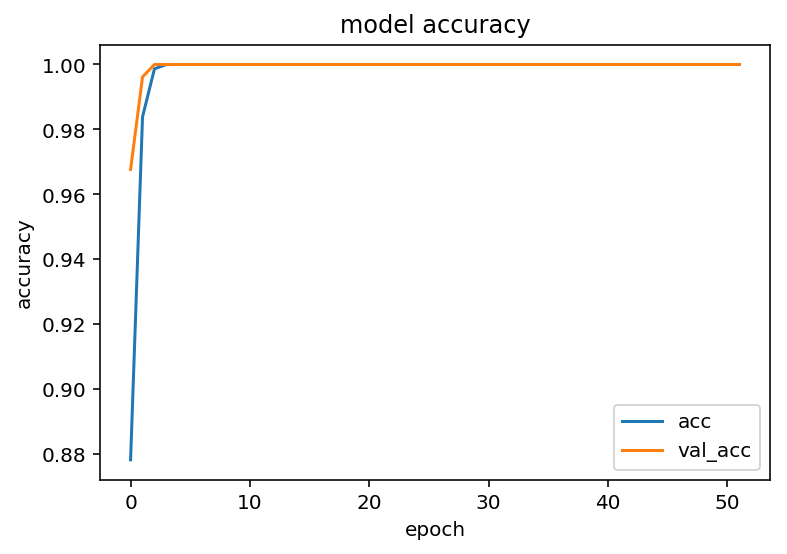

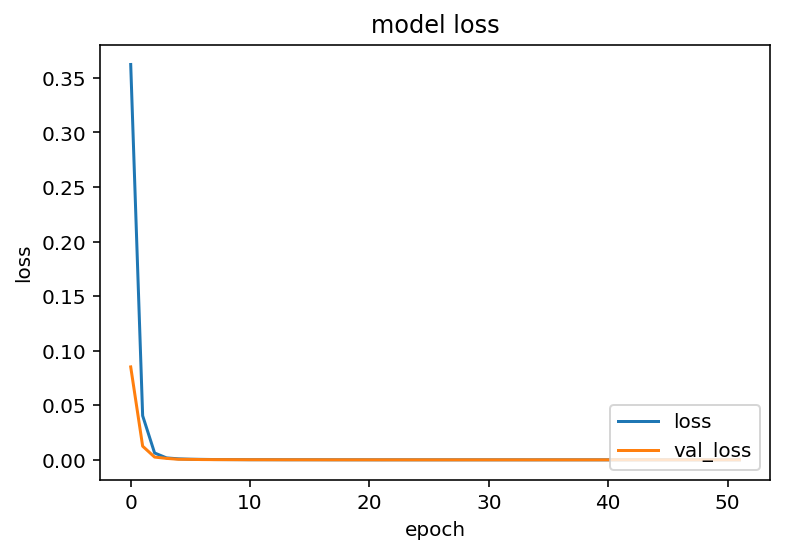

In [110]:
cb = [
    EarlyStopping(patience=30, verbose=1, min_delta=1e-5),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, epsilon=1e-5),
]

history = model.fit(X_train_split, y_train, validation_data=(X_val_split, y_val), epochs=300, batch_size=256,
                    shuffle=True, callbacks=cb)

def plot_history(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(history)

In [111]:
pred = model.predict(X_test_split) > 0.5

In [112]:
accuracy_score(pred, y_test)

1.0

# Use Embedded Features

## Get feature vectors

In [113]:
def embed_feature(X, w, num_categories):
    onehot = np.eye(num_categories)[X]
    return onehot @ w

features_train = []
for i, (name, column) in enumerate(X_train.iteritems()):
    num_categories = column.nunique()
    embedded_train = embed_feature(column, K.eval(model.weights[i]), num_categories)
    features_train.append(embedded_train)

X_train_embedded = np.concatenate(features_train, axis=1)

In [114]:
X_train_embedded

array([[ 0.01118138,  0.02626755, -0.00615095, ..., -0.00899881,
         0.0315029 , -0.01335264],
       [-0.00617144,  0.03065937, -0.01214597, ..., -0.02884202,
        -0.00245347,  0.00522686],
       [ 0.01225804, -0.00243602,  0.00343383, ..., -0.04384102,
        -0.05866847,  0.07639196],
       ..., 
       [ 0.01225804, -0.00243602,  0.00343383, ..., -0.02884202,
        -0.00245347,  0.00522686],
       [ 0.01118138,  0.02626755, -0.00615095, ..., -0.02261578,
         0.02623611, -0.00811234],
       [-0.05483118, -0.06914786, -0.06349587, ...,  0.02918827,
        -0.00549221,  0.04855845]])

In [115]:
X_train_embedded.shape

(5199, 54)

** now, we can obtain embedded 54 features ** 

## Visualize embedded features

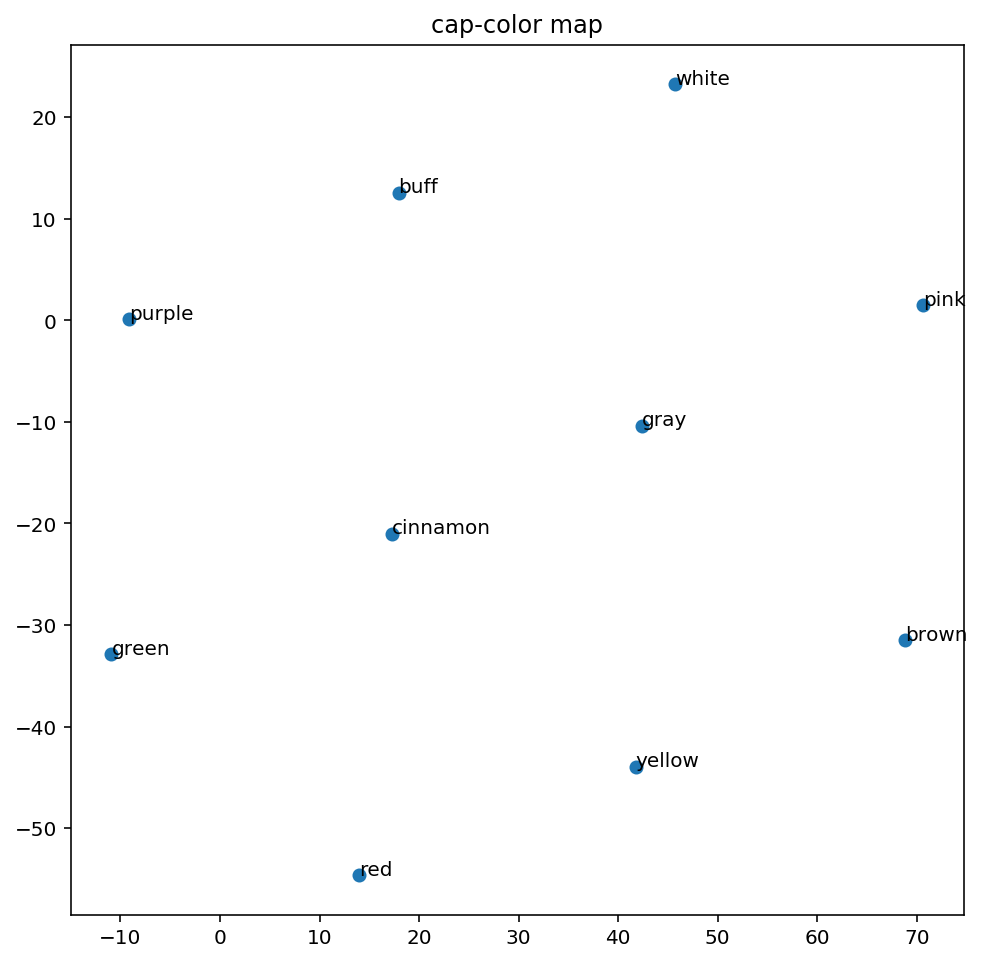

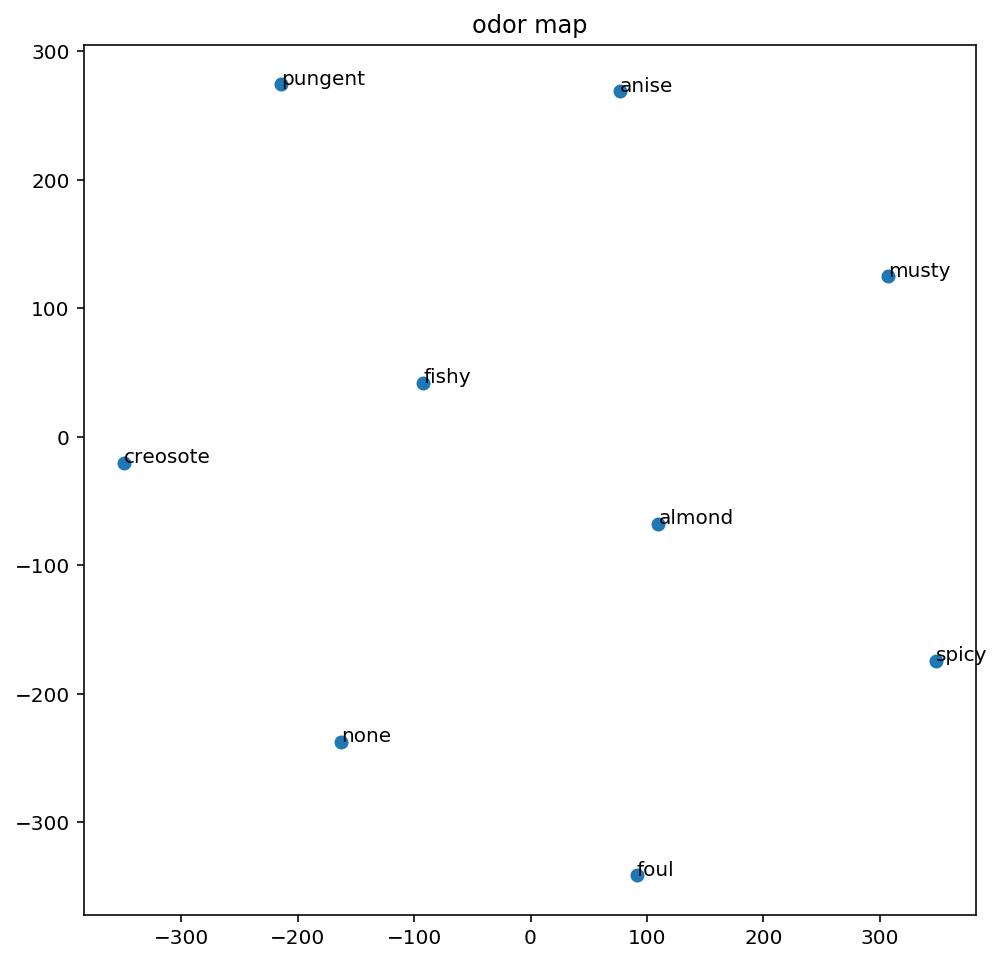

In [120]:
import pickle
from sklearn import manifold

color_embedding = K.eval(model.weights[2]) # color of cap (KASA)
odor_embedding = K.eval(model.weights[4]) # smell

# color
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(color_embedding)
names = ['buff', 'cinnamon', 'red', 'gray', 'brown', 'pink', 'green', 'purple', 'white', 'yellow']

plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
plt.title('cap-color map')
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))

#plt.savefig('dow_embedding.png')

# odor
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(odor_embedding)
names = ['almond', 'creosote', 'foul', 'anise', 'musty', 'none', 'pungent', 'spicy', 'fishy']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
plt.title('odor map')
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))

#plt.savefig('month_embedding.png')